$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}$
<body>
    <div>
        <tr><h1>
            <b><font face="Verdana">Thermal Relaxation Error Tests</font></b>
        </h1></tr>
        <p>
            We will simulate the effects of a thermal relaxation error on an ideal circuit.
        </p>
    </div>
</body>

In [1]:
import numpy as np
from qiskit import execute, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.aer import *
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, thermal_relaxation_error

First we must create a circuit where we know what the result will be. Let's try an ideal singlet state qc.

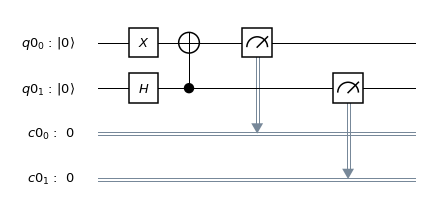

In [2]:
# prepare a singlet state
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q,c)

qc.x(q[0])
qc.h(q[1])
qc.cx(q[1],q[0])
qc.measure(q,c)
qc.draw(output='mpl')

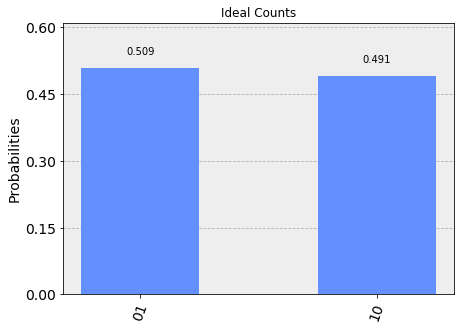

In [3]:
# perform an ideal simulation
simulator = Aer.get_backend('qasm_simulator')

result = execute(qc, simulator).result()
counts = result.get_counts(qc)
plot_histogram(counts, title='Ideal Counts')

<p>In the ideal situation, there will be a 50% chance of getting a 01 or 10 and 0% chance of getting a 00 or 11.</p>
<p>Now let's try introducing a thermal relaxation error. For this type of error, we will be changing the times it takes for certain gates to run instead of changing probabilities. A longer time will increase the likelihood of the system being affected. </p>
<p>First, let's test the time for u1.</p>

NoiseModel:
  Basis gates: ['cx', 'id', 'u1', 'u3']
  Instructions with noise: ['u1', 'cx']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('u1', [0]), ('u1', [1]), ('u1', [2]), ('u1', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


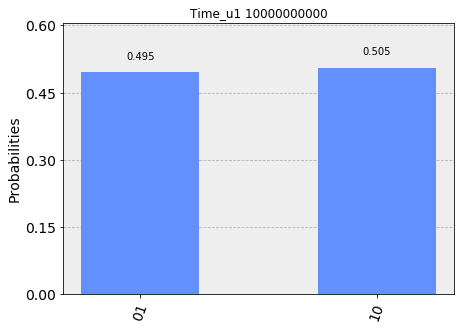

In [4]:
# thermal relaxation error
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# instruction times (in nanoseconds)
time_u1 = 10000000000   # virtual gate
time_u2 = 0  # (single X90 pulse)
time_u3 = 0 # (two X90 pulses)
time_cx = 0
time_reset = 0  # 1 microsecond
time_measure = 0 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

# perform a noisy simulation
job = execute(qc, simulator,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal)
result_thermal = job.result()
counts_thermal = result_thermal.get_counts(0)

# plot noisy output
plot_histogram(counts_thermal, title='Time_u1 10000000000')

<p>No matter what value you put in for time_u1, the circuit always remains the same as the ideal.</p>
<p>Now let's try changing u2:</p>

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['cx', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


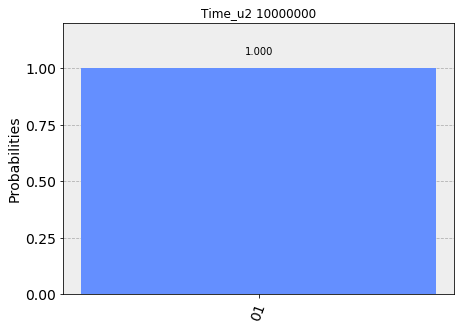

In [5]:
# thermal relaxation error
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 10000000  # (single X90 pulse)
time_u3 = 0 # (two X90 pulses)
time_cx = 0
time_reset = 0  # 1 microsecond
time_measure = 0 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

# perform a noisy simulation
job = execute(qc, simulator,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal)
result_thermal = job.result()
counts_thermal = result_thermal.get_counts(0)

# plot noisy output
plot_histogram(counts_thermal, title='Time_u2 10000000')

<p>This change will very dramatically alter our results. By trying a very large number, we will only ever get 01 as a value.</p>
<p>Let's try a smaller number:</p>

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['cx', 'u2']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


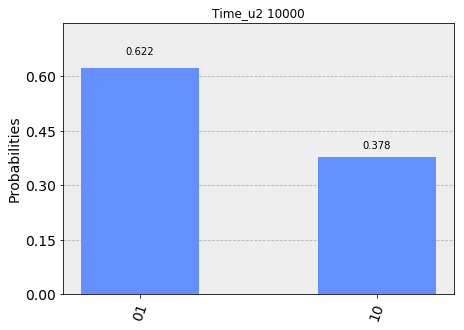

In [6]:
# thermal relaxation error
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 10000  # (single X90 pulse)
time_u3 = 0 # (two X90 pulses)
time_cx = 0
time_reset = 0  # 1 microsecond
time_measure = 0 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

# perform a noisy simulation
job = execute(qc, simulator,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal)
result_thermal = job.result()
counts_thermal = result_thermal.get_counts(0)

# plot noisy output
plot_histogram(counts_thermal, title='Time_u2 10000')

<p>Here we can see that the probability of 10 is not 0 but as we increase the value of time_u2, it will increase the probability of getting 01.</p>
<p>Now let's try changing u3:</p>

NoiseModel:
  Basis gates: ['cx', 'id', 'u3']
  Instructions with noise: ['u3', 'cx']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


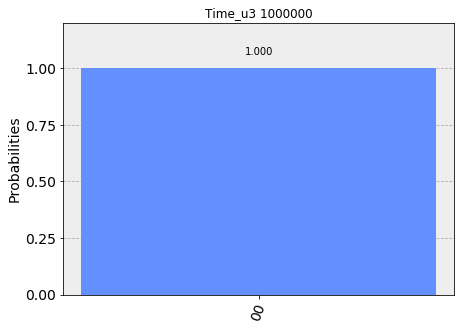

In [7]:
# thermal relaxation error
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 0  # (single X90 pulse)
time_u3 = 1000000 # (two X90 pulses)
time_cx = 0
time_reset = 0  # 1 microsecond
time_measure = 0 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

# perform a noisy simulation
job = execute(qc, simulator,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal)
result_thermal = job.result()
counts_thermal = result_thermal.get_counts(0)

# plot noisy output
plot_histogram(counts_thermal, title='Time_u3 1000000')

<p>Now trying a very large number will always give us 00.</p>
<p>Let's try decreasing the time again.</p>

NoiseModel:
  Basis gates: ['cx', 'id', 'u3']
  Instructions with noise: ['u3', 'cx']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


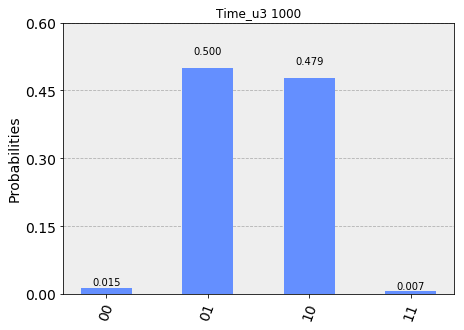

In [8]:
# thermal relaxation error
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 0  # (single X90 pulse)
time_u3 = 1000 # (two X90 pulses)
time_cx = 0
time_reset = 0  # 1 microsecond
time_measure = 0 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

# perform a noisy simulation
job = execute(qc, simulator,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal)
result_thermal = job.result()
counts_thermal = result_thermal.get_counts(0)

# plot noisy output
plot_histogram(counts_thermal, title='Time_u3 1000')

Now we can see how this resembles the ideal circuit. There is only a small percentage of 00s and 11s. As we increase the time to a value between the two values we attempted, we can see the trend of how changing time will affect the outcome.

NoiseModel:
  Basis gates: ['cx', 'id', 'u3']
  Instructions with noise: ['u3', 'cx']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [0, 2]), ('cx', [0, 3]), ('cx', [1, 0]), ('cx', [1, 1]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 0]), ('cx', [2, 1]), ('cx', [2, 2]), ('cx', [2, 3]), ('cx', [3, 0]), ('cx', [3, 1]), ('cx', [3, 2]), ('cx', [3, 3])]


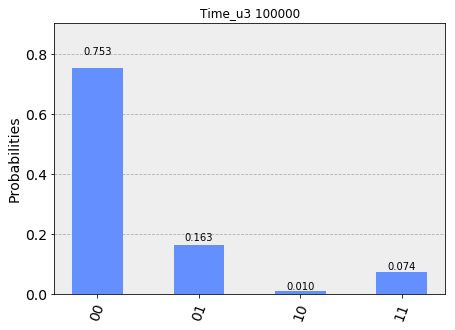

In [9]:
# thermal relaxation error
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 0  # (single X90 pulse)
time_u3 = 100000 # (two X90 pulses)
time_cx = 0
time_reset = 0  # 1 microsecond
time_measure = 0 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

# perform a noisy simulation
job = execute(qc, simulator,
              basis_gates=noise_thermal.basis_gates,
              noise_model=noise_thermal)
result_thermal = job.result()
counts_thermal = result_thermal.get_counts(0)

# plot noisy output
plot_histogram(counts_thermal, title='Time_u3 100000')